# A deep state-space model for a consumer credit risk portfolio

This notebook outlines the development of a deep state-space model for consumer credit risk, built using [pyro.ai](https://pyro.ai/). At its core, the model employs Monte Carlo simulations for each loan, progressing through monthly timesteps. The hidden state at each step represents the loan’s status, with all accounts initially starting as current. From there, loans may transition to early payoff, arrears, or more commonly, remain current and advance to the next month.

The model requires a single primary input: a vector of anticipated cashflows, representing the loan’s installment schedule. The output used for training is the corresponding sequence of realized cashflows, i.e., the actual payments made. Behind the scenes, the model also trains an embedding based on the loan account identifier, which effectively captures the performance characteristics of each specific loan. This embedding serves several purposes, including:
- Simulating the performance of the existing portfolio.
- Extending the installment schedule to maturity to estimate the portfolio’s value if allowed to run off.
- Providing a low-dimensional representation of loan performance, enabling broader analysis beyond traditional good/bad account classifications for training applicant-level models.
- Reducing to a single risk dimension that represents the probability of default over any given time horizon.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
import torch
import torch.nn.functional as F
import pyro

In [4]:
from monteloanco import Model, Guide, GroupedBatchSampler, tmat_reshape, Template

We take a subset of the 2+ million accounts available here for speed.

In [5]:
df_train = pd.read_json('training.jsonl.gz', lines=True)

In [6]:
df_train.pymnt = pd.Series([
    torch.tensor(a)[torch.tensor(b, dtype=torch.bool)]
    for a, b in zip(df_train.pymnt, df_train.train)
])

The model has been designed such that it can train / simulate a large number of accounts in parallel on a GPU. If you don't have a suitable GPU installed on your machine simply replace `cuda:0` here with `cpu`. To achieve this we need to consider how the data is to be fed into the model. One of consideration with batching the tasks is that it is preferable to present the longest sequences first as these contain the most information, but more importanly than that, that all sequences in a batch ultimately have the same length. We pad the sequences out with 0, which is perfectly applicable to both the expected and realised payment seqences.

In [7]:
device = 'cuda:0'

In [8]:
batch_size = 100_000
dataset = df_train[['id', 'installment', 'pymnt', 'loan_amnt', 'int_rate']].reset_index(names='idx').to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

With the dataset batches defined it's time to run the optimisation process, and tune the parameters. The loss here is the difference between the anticipated payment and that that was made, for every account, up to and including each timestep in the sequence.

In [9]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [18]:
%%time

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Initialize the model and guide
embedding_size=3
model = Model(embedding_size, device).to(device)
guide = Guide(embedding_size, device).to(device)

# Set up the optimizer and inference algorithm
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = pyro.infer.SVI(model=model, guide=guide, optim=optimizer, loss=pyro.infer.Trace_ELBO())

# Run inference
#num_batches = grouped_batch_sampler.__len__()
num_iterations = 5_000
with tqdm(total=num_iterations, desc="Epochs", position=0) as epoch_pbar:
    for step in range(num_iterations):
    #with tqdm(total=num_batches, desc=f"Epoch {step + 1}", position=1, leave=False) as batch_pbar:
        losses = []
        for batch_id, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
            losses.append(svi.step(
                batch_id=batch_id,
                batch_idx=torch.arange(len(batch['installment'])).to(device), 
                installments=batch['installment'].to(device), 
                loan_amnt=batch['loan_amnt'].to(device), 
                int_rate=batch['int_rate'].to(device),
                pymnts=batch['pymnt'].to(device)))
            #batch_pbar.update(1)
        if step % np.ceil(num_iterations/100) == 0:
            print(f"Step {step} : Loss = {np.sum(losses)}")
        epoch_pbar.update(1)


Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Step 0 : Loss = 179513174.94888005
Step 50 : Loss = 152808030.31364748
Step 100 : Loss = 136507471.32227212
Step 150 : Loss = 123957892.14333612
Step 200 : Loss = 114616215.49660581
Step 250 : Loss = 108133709.94140951
Step 300 : Loss = 101994388.39356217
Step 350 : Loss = 94452427.7038106
Step 400 : Loss = 87016696.77804813
Step 450 : Loss = 82656989.01834819
Step 500 : Loss = 77728096.65529737
Step 550 : Loss = 71695987.24740984
Step 600 : Loss = 68852649.40374424
Step 650 : Loss = 64373449.72738678
Step 700 : Loss = 60715532.34186183
Step 750 : Loss = 56914362.480946854
Step 800 : Loss = 53851087.561536625
Step 850 : Loss = 52745138.856184855
Step 900 : Loss = 51079762.92549653
Step 950 : Loss = 48219320.037238196
Step 1000 : Loss = 48017657.90611365
Step 1050 : Loss = 45616838.885054015
Step 1100 : Loss = 44170515.07818867
Step 1150 : Loss = 44043219.4031905
Step 1200 : Loss = 42879993.89277851
Step 1250 : Loss = 41977643.44021333
Step 1300 : Loss = 41393454.89681393
Step 1350 : Lo

Save model parameters to a file for inference in another notebook.

In [19]:
model.to(device)

Model()

In [20]:
model.__dict__['_modules']

{}

In [21]:
pyro.get_param_store().save('param_store.pt')
torch.save(model.state_dict(), 'model_params.pt')
torch.save(guide.state_dict(), "guide_params.pt")

Above you can see the progress made by the optimiser in reducing the loss. Now we can take a look at some results, and sense-check the outcome. First we'll look at the (average) transition matrix itself seeing this is what lies at the core of the model. Hopefully you can see the similarities between this and the demo I made above.

In [23]:
df_tmat = pd.DataFrame()
for batch_id, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    tmat = tmat_reshape(
        pyro.get_param_store()[f'embeddings_{batch_id}'],
        pyro.get_param_store()[f'model.weight1'],
        pyro.get_param_store()[f'model.bias1'],
        device
    )
    tmat_prior = pyro.get_param_store()[f'tmat_prior_{batch_id}']
    df_tmat_new = pd.DataFrame(zip(batch['idx'].tolist(), tmat, tmat_prior)).reset_index()
    df_tmat_new['batch_id'] = batch_id
    df_tmat = pd.concat([df_tmat, df_tmat_new])

In [24]:
df_tmat = df_tmat.set_axis(['batch_idx', 'idx', 'tmat', 'tmat_prior', 'batch_id'], axis=1)
df_tmat = df_tmat.set_index('idx').join(df_train)

In [25]:
def tmat_to_score(tmat):
    '''
    Function to identify probability of account being up to date after 12 months
    '''
    score = torch.zeros(8).to(device)
    score[1] = 1.
    for _ in range(12): score = torch.matmul(score, tmat)
    return score

In [26]:
df_tmat['score'] = df_tmat['tmat'].apply(lambda x: tmat_to_score(x)[7].item())
df_tmat['score_prior'] = df_tmat['tmat_prior'].apply(lambda x: tmat_to_score(x)[7].item())

In [27]:
df_tmat.drop(['tmat', 'tmat_prior', 'train', 'pymnt'], axis=1).to_csv('training.csv.gz', index=False)

### rank according to the model embeddings

Next we'll go into a little more detail, by looking at a few specific loan examples. To do this, we need to collapse the embeddings down to a single dimension representing the default probability after an arbitrarily long period of time. Naturally, this largely negates the purpose of determining a term-independent, multi-dimensional score in the first place, but for now we just need something to conveniently rank the accounts for the purposes of illustration. Think of this as being like a traditional credit score.

The 5 heatmaps reflect those accounts with the lowest probability of default, red cells in the first column indicate a high probability of being paid early. The transition heatmaps are followed by 50 simulations of each of these accounts and their cashflows which show for these 5 accounts, this was indeed the case.

In [28]:
df_tmat_head = df_tmat.sort_values('score').head(5)

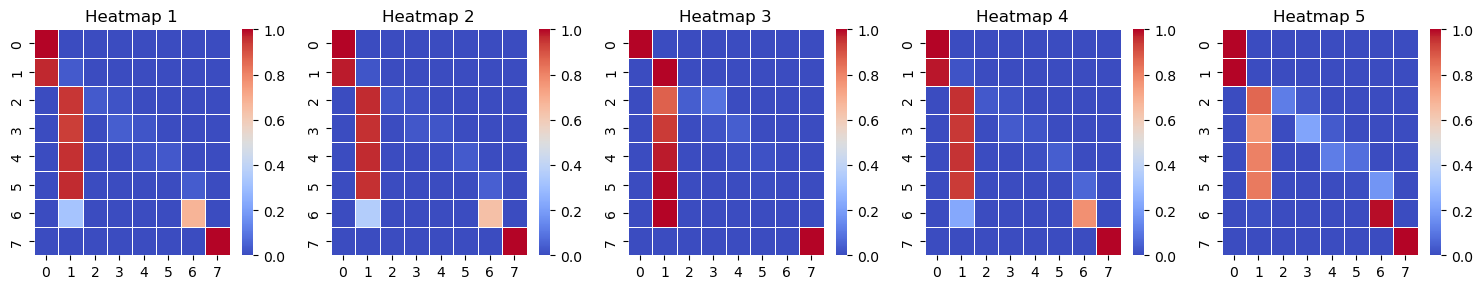

In [29]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap(df_tmat_head.iloc[i].tmat.cpu().detach().numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

The hidden state diagrams below tell a strong story for the accounts with the highest scores, most of these simulations converge on state 1 (up to date), and the corresponding actual cashflow profiles indicate these loans paying consistently for the duration of the term.

tensor(2517.9688, device='cuda:0') tensor(2530.1162) 552.16
tensor(6658.1216, device='cuda:0') tensor(6653.5601) 8128.08
tensor(848.4600, device='cuda:0') tensor(843.0600) 848.46
tensor(4857.2397, device='cuda:0') tensor(4888.9502) 5932.08
tensor(5582.3623, device='cuda:0') tensor(5510.9800) 596.28


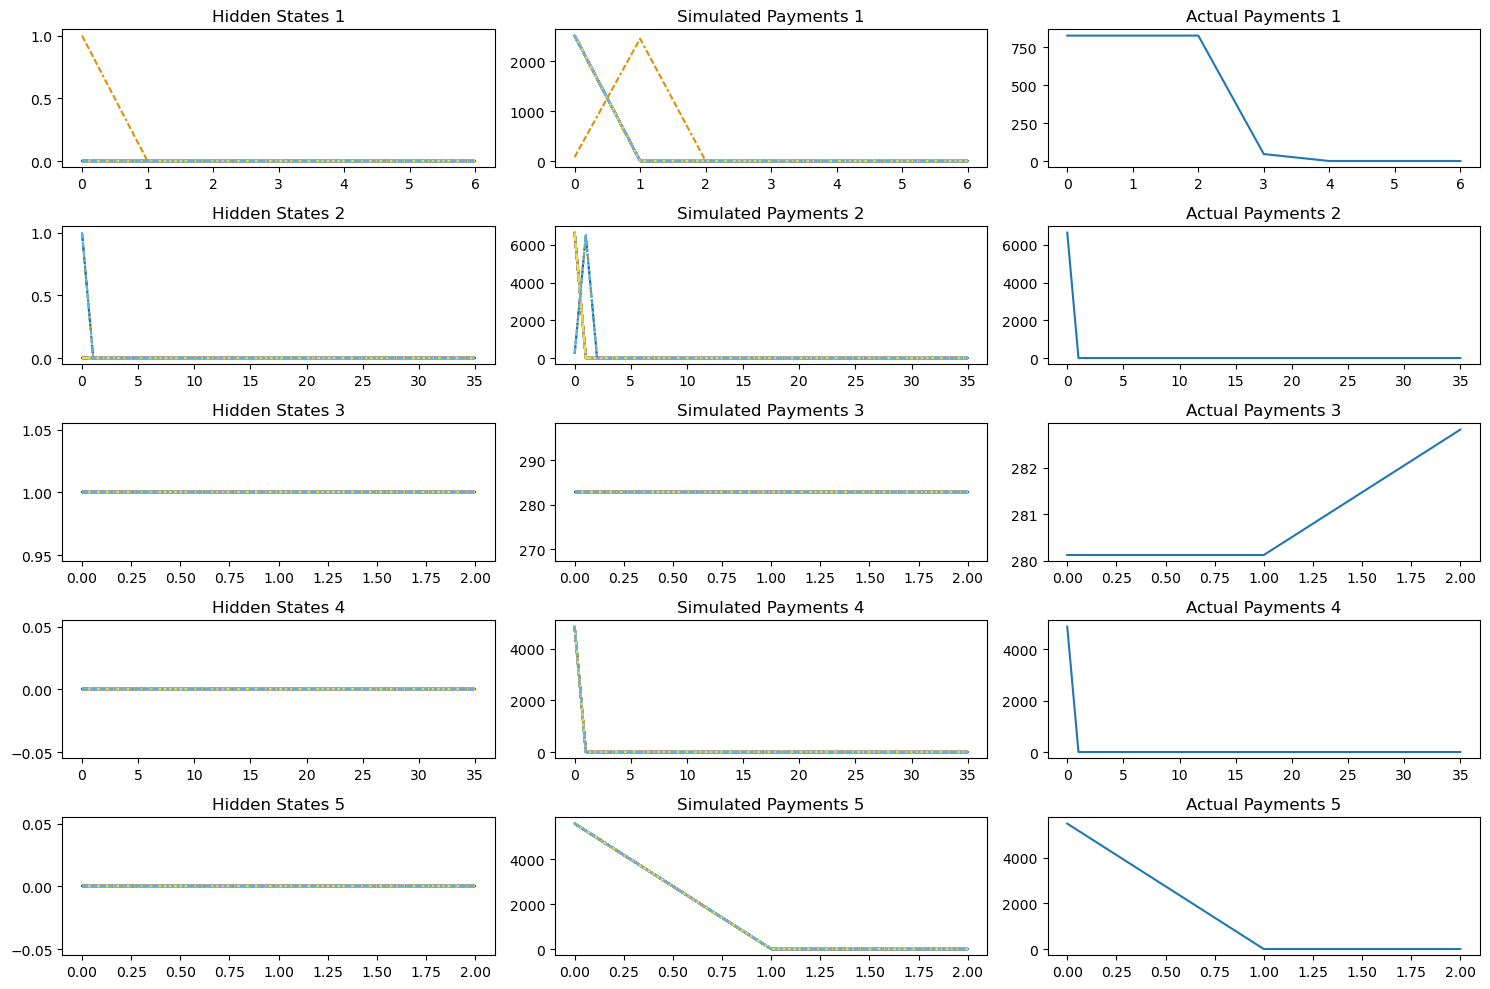

In [30]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, axs in enumerate(axes):
    loan = df_tmat_head.iloc[i].to_dict()
    hidden_states, sim_pymnts, interest_paid, principal_paid = model.forward(
        loan['batch_id'], 
        torch.tensor(loan['batch_idx']).repeat(50).to(device), 
        torch.tensor(loan['installment']).repeat(50).to(device),
        torch.tensor(loan['loan_amnt']).repeat(50).to(device),
        torch.tensor(loan['int_rate']).repeat(50).to(device),
        loan['pymnt'].repeat(50, 1).to(device))
    print(sim_pymnts.sum(0).mean(), loan['pymnt'].sum(), loan['installment']*len(loan['pymnt']))
    sns.lineplot(hidden_states.detach().cpu().numpy(), ax=axs[0], palette='colorblind', legend=False)
    sns.lineplot(sim_pymnts.detach().cpu().numpy(), ax=axs[1], palette='colorblind', legend=False)
    sns.lineplot(loan['pymnt'].detach().cpu().numpy(), ax=axs[2], legend=False)
    axs[0].set_title(f"Hidden States {i+1}")
    axs[1].set_title(f"Simulated Payments {i+1}")
    axs[2].set_title(f"Actual Payments {i+1}")
plt.tight_layout()
plt.show()

The same data is then presented for the 5 accounts with the highest probability of default. These heatmaps are characterised by deep red cells in the final column, indicating a high probability of defaulting. In paractice it's not possible to transition directly from state 1 to state 7, and you see here how the cells one step off-diagonal to the right are more probable than most, illustrating how the delinqency states slowly escalate. 

In [31]:
df_tmat_tail = df_tmat.sort_values('score').tail(5)

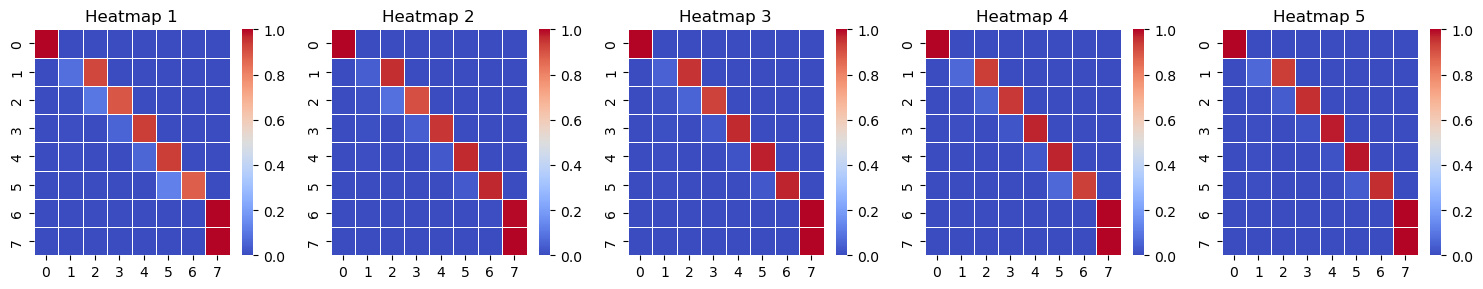

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap(df_tmat_tail.iloc[i].tmat.cpu().detach().numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

And, in similar contast to the simulations above, most simulations here are rapidly transitioning to state 7 (charge-off) from where they no longer yield any payments (simulated payments line converges on 0). Looking at the actual payments we see why this is the case, as all these accounts are charged off befor ethey reached full term.

tensor(125.6050, device='cuda:0') tensor(275.) 3014.52
tensor(182.3392, device='cuda:0') tensor(0.) 7197.599999999999
tensor(73.7260, device='cuda:0') tensor(0.) 4792.19
tensor(148.7320, device='cuda:0') tensor(0.) 6262.4
tensor(289.5594, device='cuda:0') tensor(0.) 7795.83


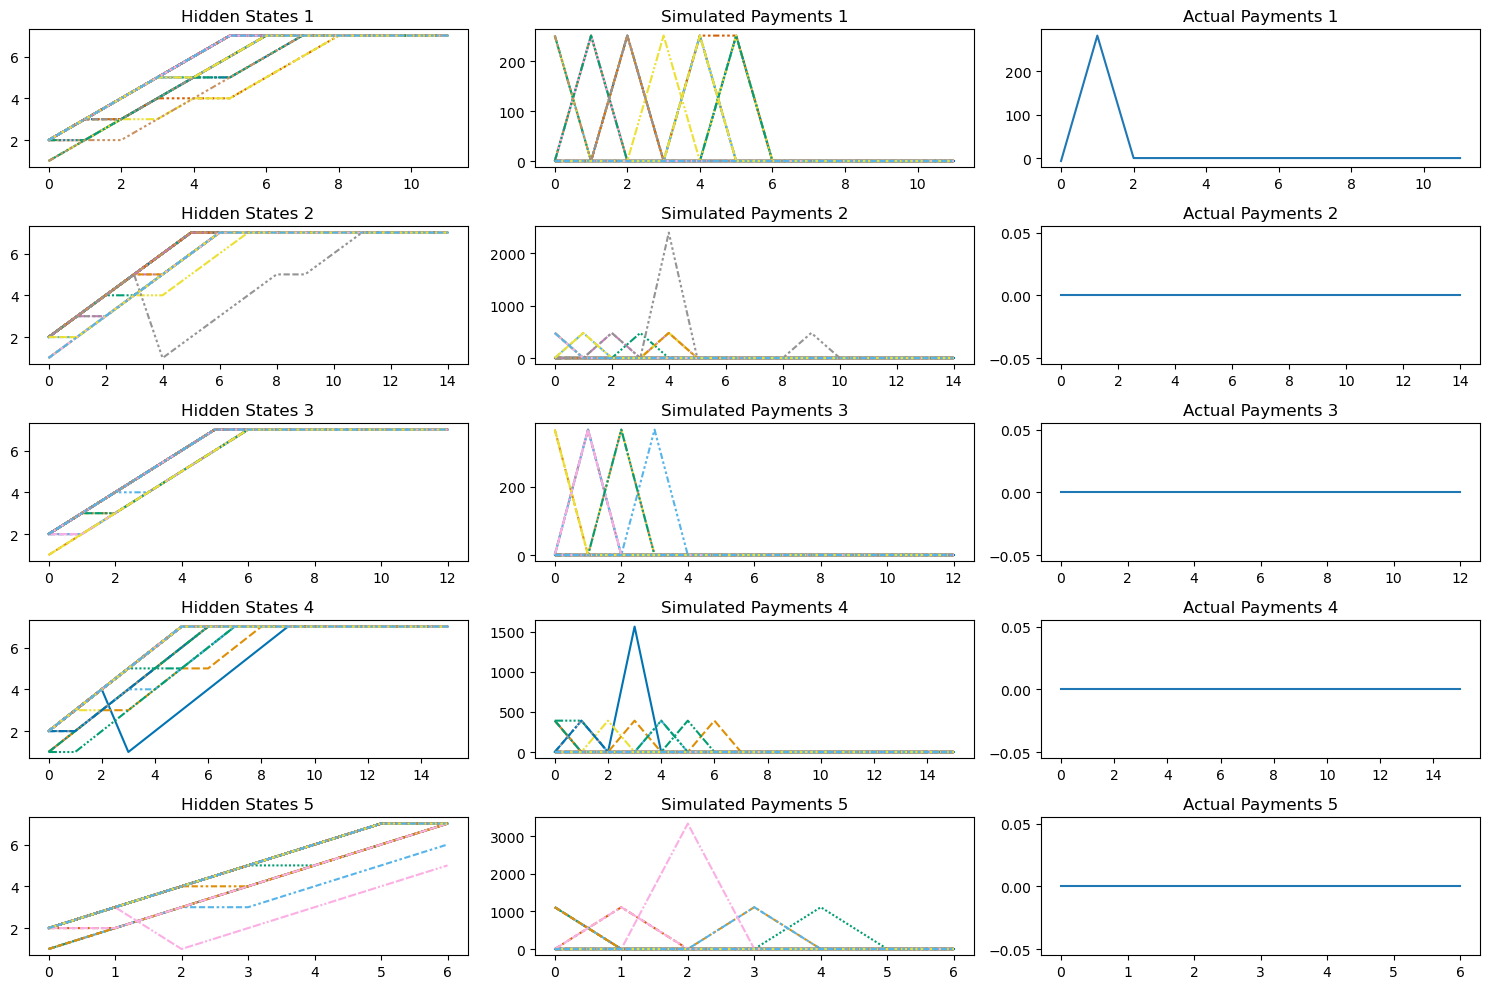

In [33]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, axs in enumerate(axes):
    loan = df_tmat_tail.iloc[i].to_dict()
    hidden_states, sim_pymnts, interest_paid, principal_paid = model.forward(
        loan['batch_id'], 
        torch.tensor(loan['batch_idx']).repeat(50).to(device), 
        torch.tensor(loan['installment']).repeat(50).to(device),
        torch.tensor(loan['loan_amnt']).repeat(50).to(device),
        torch.tensor(loan['int_rate']).repeat(50).to(device),
        loan['pymnt'].repeat(50, 1).to(device))
    print(sim_pymnts.sum(0).mean(), loan['pymnt'].sum(), loan['installment']*len(loan['pymnt']))
    sns.lineplot(hidden_states.detach().cpu().numpy(), ax=axs[0], palette='colorblind', legend=False)
    sns.lineplot(sim_pymnts.detach().cpu().numpy(), ax=axs[1], palette='colorblind', legend=False)
    sns.lineplot(loan['pymnt'].detach().cpu().numpy(), ax=axs[2], legend=False)
    axs[0].set_title(f"Hidden States {i+1}")
    axs[1].set_title(f"Simulated Payments {i+1}")
    axs[2].set_title(f"Actual Payments {i+1}")
plt.tight_layout()
plt.show()

Finally, the differences between the highest and lowest scoring accounts' heatmaps can finally be seen below. The blue cells in column 1 illustrate those accounts remaining up to date (or catching up where they are late) and the red cells in column 7 indicates those accounts being charged off.

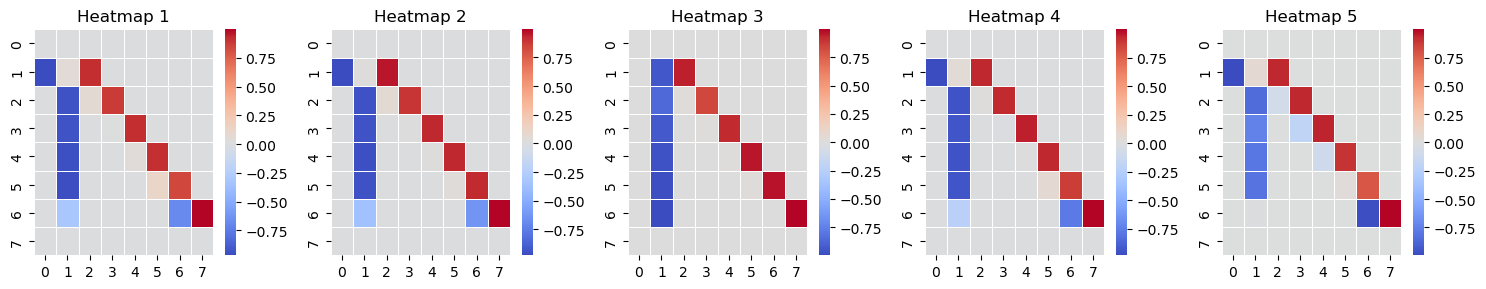

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap((df_tmat_tail.iloc[i].tmat-df_tmat_head.iloc[i].tmat).detach().to('cpu').numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

### rank according to the guide

In [35]:
df_tmat_head = df_tmat.sort_values('score_prior').head(5)

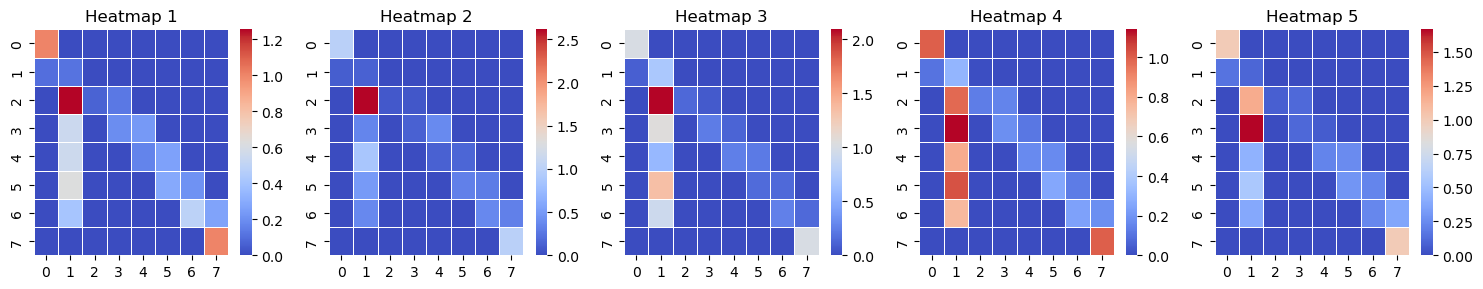

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap(df_tmat_head.iloc[i].tmat_prior.cpu().detach().numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

tensor(2556.4055, device='cuda:0') tensor(2564.8806) 805.8
tensor(2495.5984, device='cuda:0') tensor(2555.1775) 547.12
tensor(4509.8467, device='cuda:0') tensor(4598.4102) 5120.28
tensor(3611.0391, device='cuda:0') tensor(3604.4602) 3905.64
tensor(2527.1946, device='cuda:0') tensor(2555.9631) 853.49


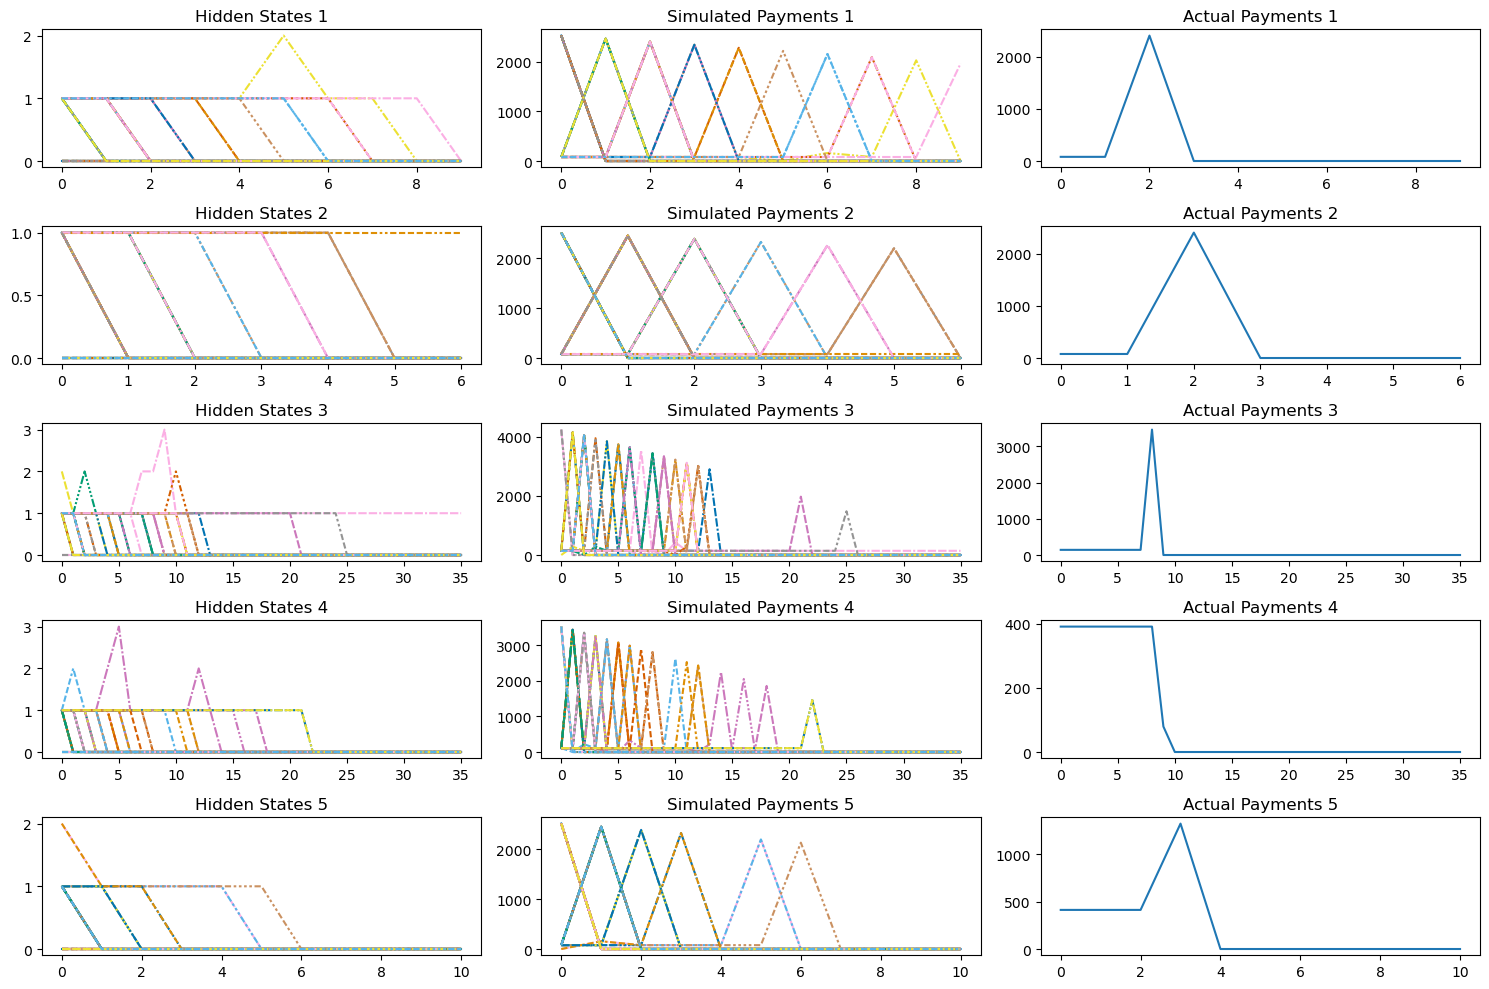

In [37]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, axs in enumerate(axes):
    loan = df_tmat_head.iloc[i].to_dict()
    hidden_states, sim_pymnts, interest_paid, principal_paid = model.forward(
        loan['batch_id'], 
        torch.tensor(loan['batch_idx']).repeat(50).to(device), 
        torch.tensor(loan['installment']).repeat(50).to(device),
        torch.tensor(loan['loan_amnt']).repeat(50).to(device),
        torch.tensor(loan['int_rate']).repeat(50).to(device),
        loan['pymnt'].repeat(50, 1).to(device))
    print(sim_pymnts.sum(0).mean(), loan['pymnt'].sum(), loan['installment']*len(loan['pymnt']))
    sns.lineplot(hidden_states.detach().cpu().numpy(), ax=axs[0], palette='colorblind', legend=False)
    sns.lineplot(sim_pymnts.detach().cpu().numpy(), ax=axs[1], palette='colorblind', legend=False)
    sns.lineplot(loan['pymnt'].detach().cpu().numpy(), ax=axs[2], legend=False)
    axs[0].set_title(f"Hidden States {i+1}")
    axs[1].set_title(f"Simulated Payments {i+1}")
    axs[2].set_title(f"Actual Payments {i+1}")
plt.tight_layout()
plt.show()

In [38]:
df_tmat_tail = df_tmat.sort_values('score_prior').tail(5)

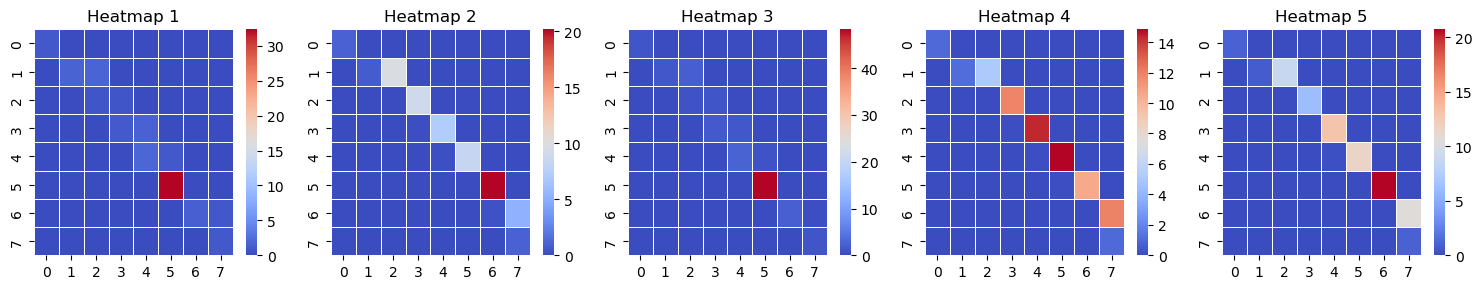

In [39]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap(df_tmat_tail.iloc[i].tmat_prior.cpu().detach().numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

tensor(10584.0723, device='cuda:0') tensor(6773.6294) 14598.72
tensor(379.0192, device='cuda:0') tensor(0.) 6091.38
tensor(18125.2148, device='cuda:0') tensor(14296.1797) 24744.32
tensor(245.2224, device='cuda:0') tensor(0.) 6130.56
tensor(178.1904, device='cuda:0') tensor(0.) 7795.83


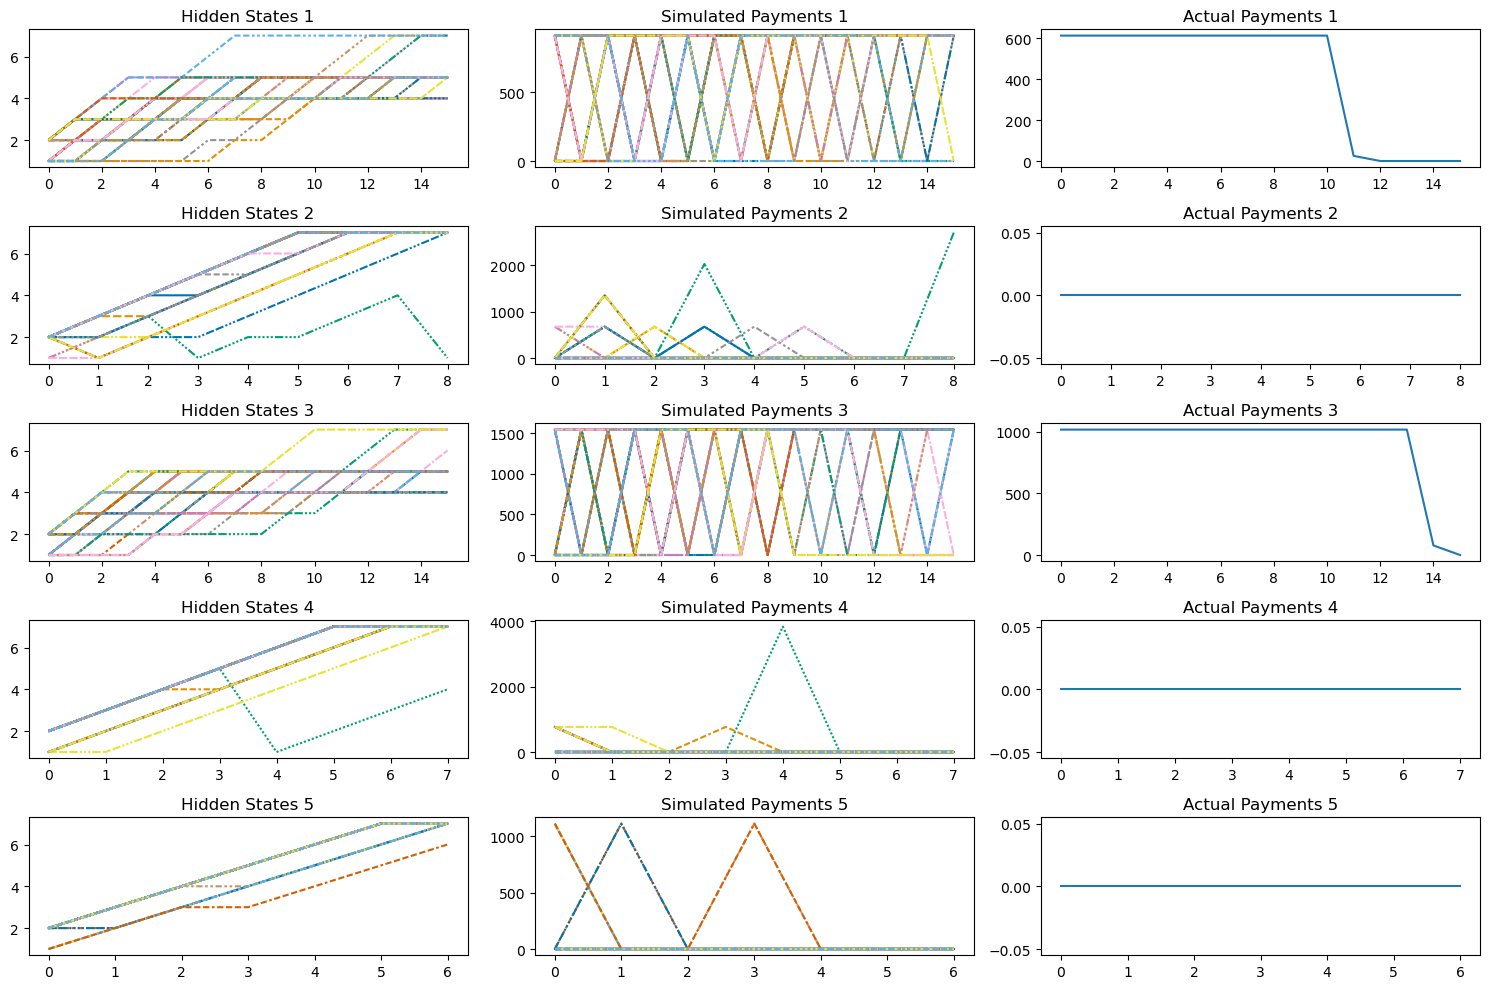

In [40]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, axs in enumerate(axes):
    loan = df_tmat_tail.iloc[i].to_dict()
    hidden_states, sim_pymnts, interest_paid, principal_paid = model.forward(
        loan['batch_id'], 
        torch.tensor(loan['batch_idx']).repeat(50).to(device), 
        torch.tensor(loan['installment']).repeat(50).to(device),
        torch.tensor(loan['loan_amnt']).repeat(50).to(device),
        torch.tensor(loan['int_rate']).repeat(50).to(device),
        loan['pymnt'].repeat(50, 1).to(device))
    print(sim_pymnts.sum(0).mean(), loan['pymnt'].sum(), loan['installment']*len(loan['pymnt']))
    sns.lineplot(hidden_states.detach().cpu().numpy(), ax=axs[0], palette='colorblind', legend=False)
    sns.lineplot(sim_pymnts.detach().cpu().numpy(), ax=axs[1], palette='colorblind', legend=False)
    sns.lineplot(loan['pymnt'].detach().cpu().numpy(), ax=axs[2], legend=False)
    axs[0].set_title(f"Hidden States {i+1}")
    axs[1].set_title(f"Simulated Payments {i+1}")
    axs[2].set_title(f"Actual Payments {i+1}")
plt.tight_layout()
plt.show()

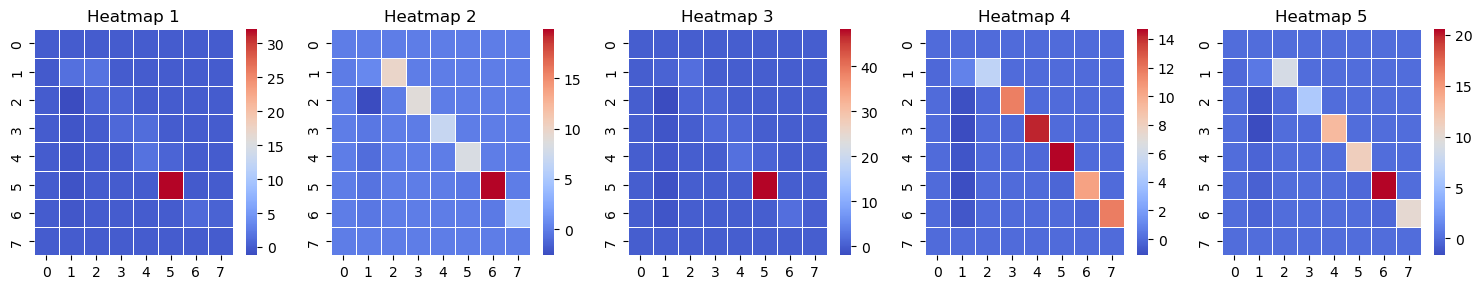

In [41]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap((df_tmat_tail.iloc[i].tmat_prior-df_tmat_head.iloc[i].tmat_prior).detach().to('cpu').numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()